In [1]:
import torch

 # `maskrcnn_resnet50_fpn`
 
 ```

    Constructs a Mask R-CNN model with a ResNet-50-FPN backbone.

    The input to the model is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each
    image, and should be in ``0-1`` range. Different images can have different sizes.

    The behavior of the model changes depending if it is in training or evaluation mode.

    During training, the model expects both the input tensors, as well as a targets (list of dictionary),
    containing:
        - boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the class label for each ground-truth box
        - masks (``UInt8Tensor[N, H, W]``): the segmentation binary masks for each instance

    The model returns a ``Dict[Tensor]`` during training, containing the classification and regression
    losses for both the RPN and the R-CNN, and the mask loss.

    During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as
    follows:
        - boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x``
          between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
        - labels (``Int64Tensor[N]``): the predicted labels for each image
        - scores (``Tensor[N]``): the scores or each prediction
        - masks (``UInt8Tensor[N, 1, H, W]``): the predicted masks for each instance, in ``0-1`` range. In order to
          obtain the final segmentation masks, the soft masks can be thresholded, generally
          with a value of 0.5 (``mask >= 0.5``)

    Mask R-CNN is exportable to ONNX for a fixed batch size with inputs images of fixed size.

    Example::

        >>> model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        >>> model.eval()
        >>> x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
        >>> predictions = model(x)
        >>>
        >>> # optionally, if you want to export the model to ONNX:
        >>> torch.onnx.export(model, x, "mask_rcnn.onnx", opset_version = 11)

    Arguments:
        pretrained (bool): If True, returns a model pre-trained on COCO train2017
        progress (bool): If True, displays a progress bar of the download to stderr
        pretrained_backbone (bool): If True, returns a model with backbone pre-trained on Imagenet
        num_classes (int): number of output classes of the model (including the background)
        trainable_backbone_layers (int): number of trainable (not frozen) resnet layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable.

```

# I/O Functions

In [2]:
# From: https://www.kaggle.com/eigrad/convert-rle-to-bounding-box-x0-y0-x1-y1
import numpy as np


def rle2bbox(rle, shape):
    '''
    rle: run-length encoded image mask, as string
    shape: (height, width) of image on which RLE was produced
    Returns (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    
    Note on image vs np.array dimensions:
    
        np.array implies the `[y, x]` indexing order in terms of image dimensions,
        so the variable on `shape[0]` is `y`, and the variable on the `shape[1]` is `x`,
        hence the result would be correct (x0,y0,x1,y1) in terms of image dimensions
        for RLE-encoded indices of np.array (which are produced by widely used kernels
        and are used in most kaggle competitions datasets)
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1


# From: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_to_bboxes(in_mask_list, N, shape=(768,768)):
    if N == 0:
        return None
    bbox_array = np.empty((N, 4), dtype=np.float32)
    i = 0
    for rle in in_mask_list:
        if isinstance(rle, str):
            # bbox = tuple(x1, y1, x2, y2)
            bbox = rle2bbox(rle, shape)
            bbox_array[i,:] = bbox
            i += 1
    return torch.from_numpy(bbox_array)


def masks_as_tensor(in_mask_list, N, shape=(768, 768)):
    if N == 0:
        return None
    masks = np.empty((N, shape[0], shape[1]), dtype=np.uint8)
    i = 0
    for mask in in_mask_list:
        if isinstance(mask, str):
            masks[i, :, :] = rle_decode(mask)
            i += 1
    
    return torch.from_numpy(masks)

In [3]:
from torch.utils.data import Dataset
from skimage.io import imread


class ShipDataset(Dataset):
    def __init__(self, in_df, transforms=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transforms = transforms
        self.mode = mode
#        self.img_transform = Compose([
#        ToTensor(),
#        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        in_mask_list = self.image_masks[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)

        image = imread(rgb_path)

        N = sum([1 for i in in_mask_list if isinstance(i, str)])
        # Make target dict
        masks = masks_as_tensor(in_mask_list, N)
        bboxes = masks_to_bboxes(in_mask_list, N)
        labels = labels = torch.ones((N,), dtype=torch.int64)
        target = {
                  'boxes': bboxes,
                  'labels': labels,
                  'masks': masks
        }
               
        if self.transforms is not None:
            image, mask = self.transforms(image, target)

        return image, target

### I/O Function Tests

In [4]:
bbox_tensor = np.empty((1, 4), dtype=np.int16)
i = 0
bbox_tensor[i,:] = (1,2,3,4)
torch.from_numpy(bbox_tensor).shape[0]

shape = (500, 500)
masks = np.empty((1, shape[0], shape[1]))

In [5]:
in_mask_list = ['85642 6 86409 8 87176 10 87943 11']
N = sum([1 for i in in_mask_list if isinstance(i, str)])
# Make target dict
masks = masks_as_tensor(in_mask_list, N)
bboxes = masks_to_bboxes(in_mask_list, N)
labels = torch.tensor([0 for i in range(N)], dtype=torch.int64)
target = {
          'boxes': bboxes,
          'labels': labels,
          'masks': masks
}

target

{'boxes': tensor([[111., 390., 114., 401.]]),
 'labels': tensor([0]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)}

# `maskrcnn_resnet50_fpn` Code

From : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
#import os
#
#
#%%shell
#
# Download TorchVision repo to use some files from
# references/detection
#os.system(
#    'git clone https://github.com/pytorch/vision.git & \
#    cd vision & \
#    git checkout v0.3.0 & \
#)

In [8]:
#!cp vision/references/detection/utils.py ./ 
#!cp vision/references/detection/transforms.py ./ 
#!cp vision/references/detection/coco_eval.py ./ 
#!cp vision/references/detection/engine.py ./ 
#!cp vision/references/detection/coco_utils.py ./

In [9]:
!pip install pycocotools

from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
import os 
import pandas as pd


def get_box_size(rle):
    if type(rle) is not str:
        return float('inf')
    s = rle.split()
    length = sum([int(x) for x in s[1:][::2]])
    return length


def filter_ids(masks, max_thresh=300, n_neg_samples = 50000):
    # Remove duplicates using set
    id_set_1 = set(masks.loc[masks['EncodedPixels'].apply(
        lambda x: get_box_size(x) <= max_thresh
        )]['ImageId'].tolist())
#    id_set_2 = set(masks.loc[masks['EncodedPixels'].apply(
#        lambda x: isinstance(x, str)
#        )]['ImageId'].tolist())
#    id_set_2 = set(masks.drop(
#        masks[masks.EncodedPixels.notnull()].index).sample(50000).index)
    id_set_2 = set(masks.drop(
            masks[masks.EncodedPixels.notnull()].index
            ).sample(n_neg_samples).ImageId.tolist())
    
    return list(id_set_1.union(id_set_2))


# Make filepaths
ship_dir = r'../../airbus-dataset/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test')

masks = pd.read_csv('../../airbus-dataset/train_ship_segmentations_v2.csv')

max_thresh = 300
# Pandas == cancer
labeled_masks = masks.groupby('ImageId').apply(lambda grp: grp.EncodedPixels.apply(
    lambda rle: get_box_size(rle) <= max_thresh).any()
                                               ).reset_index(name='counts')

filtered_masks = masks[
    masks.ImageId.isin(labeled_masks[labeled_masks.counts == True].ImageId)]
null_masks = masks[
    masks.EncodedPixels.isnull()].sample(filtered_masks.shape[0],random_state=42)
#masks = pd.concat((filtered_masks, null_masks))
#masks.shape[0] == filtered_masks.shape[0] * 2

In [11]:
# use our dataset and defined transformations
dataset = ShipDataset(filtered_masks, get_transform(train=True))
dataset_valid = ShipDataset(filtered_masks, get_transform(train=False))

# split the dataset in train and validation set
valid_size = 5000
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-valid_size])
dataset_valid = torch.utils.data.Subset(dataset_valid, indices[-valid_size:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=32, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [12]:
dataset.__len__()

15997

In [13]:
dataset_valid.__len__()

5000

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [15]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1e1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

Epoch: [0]  [   0/1000]  eta: 1:47:00  lr: 0.000010  loss: 4.4268 (4.4268)  loss_classifier: 0.6821 (0.6821)  loss_box_reg: 0.0605 (0.0605)  loss_mask: 2.1676 (2.1676)  loss_objectness: 1.3008 (1.3008)  loss_rpn_box_reg: 0.2159 (0.2159)  time: 6.4202  data: 1.8682  max mem: 10831
Epoch: [0]  [  10/1000]  eta: 1:05:23  lr: 0.000060  loss: 4.1581 (4.3156)  loss_classifier: 0.6190 (0.5800)  loss_box_reg: 0.0651 (0.0674)  loss_mask: 1.6127 (1.7453)  loss_objectness: 1.6368 (1.6563)  loss_rpn_box_reg: 0.2281 (0.2666)  time: 3.9632  data: 0.2012  max mem: 10831
Epoch: [0]  [  20/1000]  eta: 1:04:32  lr: 0.000110  loss: 2.4625 (3.0516)  loss_classifier: 0.3962 (0.4308)  loss_box_reg: 0.0726 (0.0733)  loss_mask: 1.2811 (1.3336)  loss_objectness: 0.4500 (1.0050)  loss_rpn_box_reg: 0.1810 (0.2089)  time: 3.8285  data: 0.0354  max mem: 10831
Epoch: [0]  [  30/1000]  eta: 1:03:48  lr: 0.000160  loss: 1.0650 (2.3861)  loss_classifier: 0.1785 (0.3393)  loss_box_reg: 0.0758 (0.0727)  loss_mask: 0.592

SystemExit: 1

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [55]:
# pick one image from the test set
img, _ = dataset_valid[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

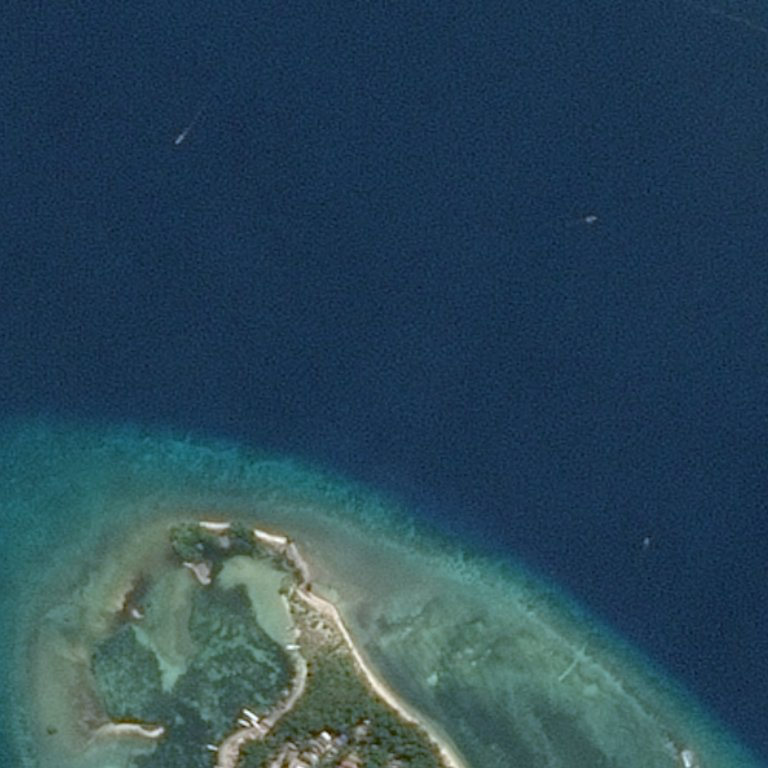

In [56]:
from PIL import Image


Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

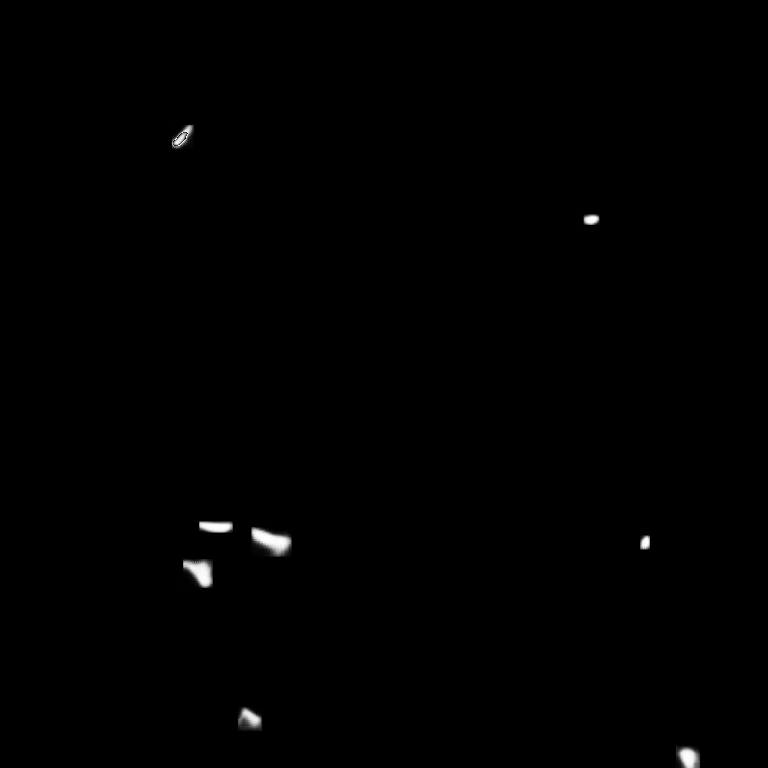

In [71]:
n_pos = len(prediction[0]['scores'][(prediction[0]['scores'] > 0.65)])

masks = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
for mask in prediction[0]['masks'][1:n_pos, 0]:
    masks += mask.mul(255).byte().cpu().numpy()
    
Image.fromarray(masks)

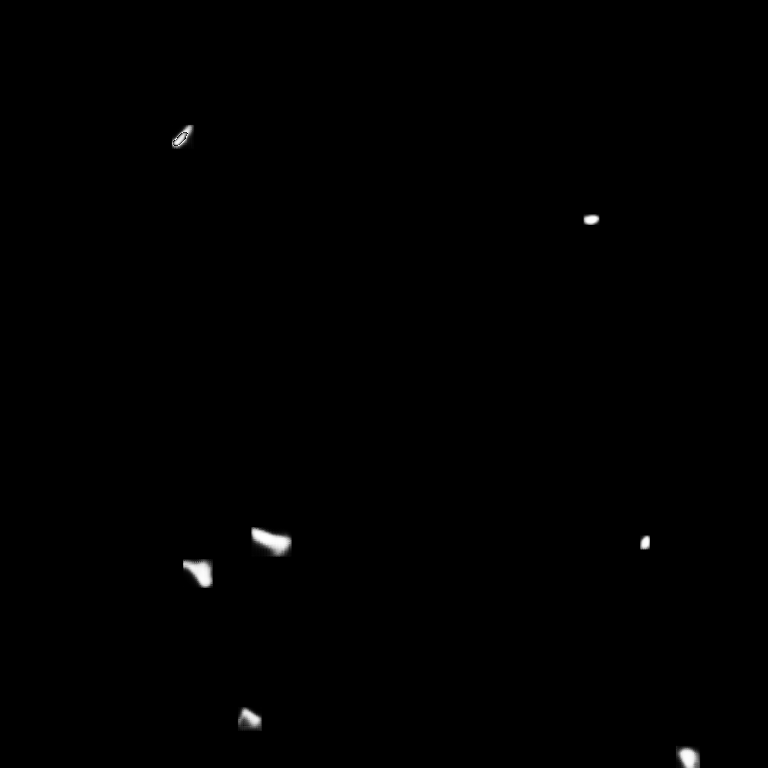